### This script is used to aggregate point features into line street segment using Fiona

#### The segmentation label and idx

Building: 1

Sky: 2

Trees: 4

Grass: 9

Sidewalk: 11


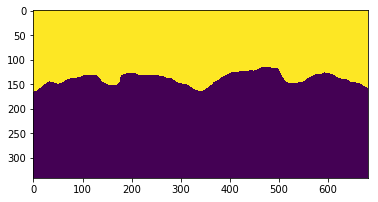

In [45]:
import os, os.path
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt


root = '/home/xiaojiang/xiaojiang/thermal-injustice/datasets/SF'
segImgfiles = os.path.join(root, 'seg_cylindri_panos')
segImgfile = os.path.join(segImgfiles, '37.782357118627395 - -122.48383681746463 - 356.718 - 2014-03_seg.png')

segImg = np.asarray(Image.open(segImgfile))

plt.imshow(segImg==2)
plt.show()


#### Read the schema of the shapefile

In [30]:
import os, os.path
import sys
import fiona
from shapely.geometry import LineString, mapping, shape, Point
from shapely.ops import transform, unary_union
import rtree

root = r'/home/xiaojiang/xiaojiang/thermal-injustice/datasets/SF/spatial-data/'

# the output sunexpo shapefile
shpfile = os.path.join(root, 'SF_gvi_svf.shp')
lineshpFile = os.path.join(root, 'tl_2014_06075_roads_wgs84.shp')

datasource = fiona.open(shpfile, 'r')

crs = datasource.crs
datasource.schema

{'geometry': 'Point',
 'properties': OrderedDict([('PntNum', 'int:9'),
              ('panoID', 'str:80'),
              ('panoDate', 'str:80'),
              ('svf', 'float:24.15'),
              ('yaw', 'float:24.15'),
              ('gvi', 'float:24.15'),
              ('layer', 'str:100'),
              ('path', 'str:200')])}

In [40]:
datasource.schema['properties'].keys()

odict_keys(['PntNum', 'panoID', 'panoDate', 'svf', 'yaw', 'gvi', 'layer', 'path'])

In [46]:
prop = datasource.schema['properties']

In [47]:
for key, value in prop.items(): 
    print (key, value)

PntNum int:9
panoID str:80
panoDate str:80
svf float:24.15
yaw float:24.15
gvi float:24.15
layer str:100
path str:200


#### Save the attribute values of shapefile into lists

In [8]:
expo_records = []
fieldlist = ['gvi', 'yaw', 'svf']

with fiona.open(shpfile, 'r') as expo:
    for feat in expo:
        item = {}
        for field in fieldlist:
            attr = feat['properties'][field]
            item.update({field: attr})
            
#         lon = feat['properties']['longitude']
#         lat = feat['properties']['latitude']
#         point = Point(float(lon), float(lat))
#         print ('The created geom object is:', point)
        
        # add the point geom to the dictionary
        pnt_geom = shape(feat['geometry'])
        item.update({'point': pnt_geom})
        
        expo_records.append(item)
        

In [13]:
len(expo_records)
expo_records[0]['svf']


0.792584341202498

#### Split the roads into shorter lines
The following code recursively splits the line in half until it is shorter than the maximum desired length.

In order make the result more reasonable, we need to split the long street segment into shorter street segments, cite from https://www.azavea.com/blog/2016/10/05/philippines-road-safety-using-shapely-fiona-locate-high-risk-traffic-areas/

In [14]:
# using recursive statement to split longer roads into shorter segments
# Reference: https://www.azavea.com/blog/2016/10/05/philippines-road-safety-using-shapely-fiona-locate-high-risk-traffic-areas/

def split_line(line, max_line_units):
    '''
    The input:
        line: the LineString object
        max_line_units: the split distance, be careful of the units
    output:
        a list of LineString segment
    '''
    
    if line.length <= max_line_units:
        return [line]
    
    half_length = line.length / 2
    coords = list(line.coords)
    
    for idx, point in enumerate(coords):
        proj_dist = line.project(Point(point))
        if proj_dist == half_length:
            return [LineString(coords[:idx + 1]), LineString(coords[idx:])]
        
        if proj_dist > half_length:
            mid_point = line.interpolate(half_length)
            head_line = LineString(coords[:idx] + [(mid_point.x, mid_point.y)])
            tail_line = LineString([(mid_point.x, mid_point.y)] + coords[idx:])
            return split_line(head_line, max_line_units) + split_line(tail_line, max_line_units)


#### Split lines into shorter street segments, keep the attribute of street

This session also output the shorter street segments into a shapefile, although this is not necessary. The returned results will be saved into a list split_lines, which stores all LineString items.


There is one more option, you can go to the SamplingLib.py to find the function of "createStreetSegment"

In [15]:

def SplitStreets2Segments(streetMap, segStreetMap, distance):
    '''
    This function is used to split the streets into shorter street segments for visualization
    and spatial analyses and modeling purposes
    
    parameters:
        streetMap: the original street feature class
        segStreetMap: the filename of the output street segment
        distance: the distance of the spliting the distance
    
    example:
        root = r'/home/xiaojiang/xiaojiang/tokyo-proj/shibuya-proj/spatial-data/'
        streetMap = os.path.join(root, 'Japan_highway_shibuya.shp')
        segStreetMap = os.path.join(root, 'seg_Japan_highway_shibuya.shp')
        
        SplitStreets2Segments(streetMap, segStreetMap, 40)
    
    
    Copyright(c) Xiaojiang Li, MIT Senseable City Lab 
    Last modified Dec 2ed, 2018
    '''
    
    import pyproj
    from shapely.ops import transform
    from functools import partial
    
    split_lines = []
    
    with fiona.open(streetMap, 'r') as streets:
        crs = streets.crs
        schema = streets.schema.copy()
        
        with fiona.open(segStreetMap, 'w', driver="ESRI Shapefile", crs=crs, schema=schema) as output_segment:
            for street in streets:            
                street_attr = street['properties']            
                street_geom = street['geometry']
                featureType = street_geom['type']
                
                # check if the linear feature is LineString or Multi-Line String
                if featureType == 'MultiLineString':
                    print('This is a MultiLineString')
                    multi_street_geom_degree = shape(street_geom)
                    
                    for singleLine_degree in multi_street_geom_degree:
                        length = singleLine_degree.length
                        # partition each single line in the multiline
                        project = partial(pyproj.transform,pyproj.Proj(init='EPSG:4326'),pyproj.Proj(init='EPSG:3857')) #3857 is psudo WGS84 the unit is meter
                        singleLine_meter = transform(project, singleLine_degree)
                        
                        street_segments = split_line(singleLine_meter, distance)
                        split_lines.extend(street_segments)
                        
                        # save the splitted segment to a shapefile
                        for street_segment in street_segments:                
                            project2 = partial(pyproj.transform,pyproj.Proj(init='EPSG:3857'),pyproj.Proj(init='EPSG:4326'))
                            street_segment_deg = transform(project2, street_segment)

                            output_segment.write({
                                'geometry': mapping(street_segment_deg),
                                'properties': dict(street_attr)
                            })
                
                elif featureType == 'LineString': 
                    # RouteName = street['properties']['FULLNAME']
                    street_geom_degree = shape(street_geom)
                    
                    # convert degree to meter, in order to split by distance in meter
                    project = partial(pyproj.transform,pyproj.Proj(init='EPSG:4326'),pyproj.Proj(init='EPSG:3857')) #3857 is psudo WGS84 the unit is meter
                    street_geom_meter = transform(project, street_geom_degree)
                    
                    street_segments = split_line(street_geom_meter, distance)
                    split_lines.extend(street_segments)
                    
                    # save the splitted segment to a shapefile
                    for street_segment in street_segments:                
                        project2 = partial(pyproj.transform,pyproj.Proj(init='EPSG:3857'),pyproj.Proj(init='EPSG:4326'))
                        street_segment_deg = transform(project2, street_segment)
                        
                        output_segment.write({
                            'geometry': mapping(street_segment_deg),
                            'properties': dict(street_attr) # this is important statement to save all the previous properties
                        })
                        
                        
    return split_lines
    

In [18]:
root = r'/home/xiaojiang/xiaojiang/thermal-injustice/datasets/SF/spatial-data/'

streetMap = os.path.join(root, 'Japan_highway_shibuya.shp')
segStreetMap = os.path.join(root, 'seg_Japan_highway_shibuya.shp')

streetMap = os.path.join(root, 'Shibuya_streetNetwork_noMotorway.shp')
segStreetMap = os.path.join(root, 'seg_Shibuya_streetNetwork_noMotorway.shp')

streetMap = os.path.join(root, 'tl_2014_06075_roads_wgs84.shp')
segStreetMap = os.path.join(root, 'tl_2014_06075_roads_wgs84_400m.shp')


split_lines = SplitStreets2Segments(streetMap, segStreetMap, 400)


This is a MultiLineString
This is a MultiLineString
This is a MultiLineString
This is a MultiLineString
This is a MultiLineString
This is a MultiLineString
This is a MultiLineString
This is a MultiLineString
This is a MultiLineString
This is a MultiLineString
This is a MultiLineString
This is a MultiLineString
This is a MultiLineString
This is a MultiLineString
This is a MultiLineString


In [20]:
# keys = street_attr.keys()
# att = dict(street_attr)
# print('The attribute keys are:', keys)
# print('The dictionary created is:', att)

file = fiona.open(segStreetMap)
file.schema
# print('the crs of the output shapefile is:', file.crs)


{'geometry': 'LineString',
 'properties': OrderedDict([('LINEARID', 'str:22'),
              ('FULLNAME', 'str:100'),
              ('RTTYP', 'str:1'),
              ('MTFCC', 'str:5')])}

#### Create linear segments with buffer distance of 50 meter, because the split_line records the geo in projection of EPSG:3857, the unit is meter

The number of element is: 11132


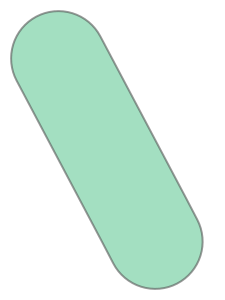

In [21]:

segments_rtree_index = rtree.index.Index()

i = 0
for idx, element in enumerate(split_lines):
    i = i + 1
    segments_rtree_index.insert(idx, element.buffer(50).bounds)
    
# segments_rtree_index

print('The number of element is:', i)

element.buffer(1).bounds
# print('The boundary of the expo site is:', element.buffer(50))
element.buffer(50)


In [23]:

expo_records[0]['point'].bounds
# expo_records_deg.bounds


(-122.46571821458478,
 37.75534307849783,
 -122.46571821458478,
 37.75534307849783)

#### Using r-tree to do the spatial operations

In [24]:

from functools import partial
import pyproj

# model to convert the unit of WGS84 from degree to meter
wgs_deg2meter_model = partial(pyproj.transform,pyproj.Proj(init='EPSG:4326'),pyproj.Proj(init='EPSG:3857'))

# use a dictionary to store the intersected point features
segments_with_records = {}

for record in expo_records:
    record_pnt = record['point']
    record_pnt_meter = transform(wgs_deg2meter_model, record_pnt)
    
    # use rtree index to find the intersected roads
    inter_roads = segments_rtree_index.intersection(record_pnt_meter.bounds)
    road_id_inter = [(segment_id, split_lines[segment_id].distance(record_pnt_meter)) for segment_id in inter_roads]
    
    
    # find the neareast pnts
    if len(road_id_inter):
        nearest = min(road_id_inter, key=lambda tup: tup[1])
        segment_id = nearest[0]
        
        # create an empty list to store the sunglare records for all street segments
        if segment_id not in segments_with_records:
            segments_with_records[segment_id] = []
        
        segments_with_records[segment_id].append(record)
        

In [25]:
len(segments_with_records)
# segments_with_records[22674]


10071

In [27]:

import numpy as np

outputShp = os.path.join(root, 'SVF_GVI_Line_SF.shp')
schema = {
    'geometry': 'LineString',
    'properties': {
        'yaw': 'float',
        'svf': 'float',
        'gvi': 'float'
    }
}


with fiona.open(outputShp, 'w', driver="ESRI Shapefile", schema=schema, crs=crs) as output:
    for idx, segment in enumerate(split_lines):
        segment_geom = segment
        
        records = segments_with_records.get(idx)
        
        if records is None: #6 No GSV point on street segment, then assign them to -1
            yaw_ave = -999
            svf_ave = -999
            gvi_ave = -999
        else: 
            # create empty list of the sunrise and sunset glare
            yaw_list = []
            svf_list = []
            gvi_list = []
            
            # loop the records to calculate the mean sunglare duration
            for record in records:
                yaw_list.append(record['yaw'])
                svf_list.append(record['svf'])
                gvi_list.append(record['gvi'])
                
            yaw_ave = sum(yaw_list)/float(len(yaw_list) + 0.0001)
            svf_ave = sum(svf_list)/float(len(svf_list) + 0.0001)
            gvi_ave = sum(gvi_list)/float(len(gvi_list) + 0.0001)
    #         print('The sunlight exposure is:', sunexpo9_ave)
            
        # the data of the record
        data = {
            'yaw': yaw_ave,
            'svf': svf_ave,
            'gvi': gvi_ave
        }
        
        
        wgs_meter2deg_model = partial(pyproj.transform,pyproj.Proj(init='EPSG:3857'),pyproj.Proj(init='EPSG:4326'))
        segment_geom_deg = transform(wgs_meter2deg_model, segment_geom)
        
        
        # write to the output shapefile
        output.write({
            'geometry': mapping(segment_geom_deg),
            'properties': data
        })
    
    
    print('You saved the shapefile successfully!')

You saved the shapefile successfully!


In [ ]:
segment_geom_deg.bounds